PROBABILIDAD DE DEFAULT DE LOS TITULOS ARGENTINOS

In [15]:
#Importo librerias (e instalo alguna si hace falta)
#pip install yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
import scipy.stats as scs
import scipy.optimize as sco
from scipy import interpolate
import statsmodels.api as sm
import pandas_datareader as pdr
import datetime

In [9]:
#pip install openpyxl

In [3]:
#pip install yfinance
#pip install seaborn
#pip install statsmodels

In [8]:
#Import the cash flows of the national bond AL30
excel = 'C:/Users/sanchezj/OneDrive/UCEMA/Quant - Finanzas Cuantitativas/TP Final/GitHub/tp_quant_Git Desktop/tp_quant/AL30.xlsx'
sheet = 'FF'
df = pd.read_excel(excel, sheet_name=sheet, index_col='Fecha Pago')
df.index = pd.to_datetime(df.index)

#Import the prices of each day
excel = 'C:/Users/sanchezj/OneDrive/UCEMA/Quant - Finanzas Cuantitativas/TP Final/GitHub/tp_quant_Git Desktop/tp_quant/AL30.xlsx'
sheet = 'PRICES'
prices = pd.read_excel(excel, sheet_name=sheet, index_col='date')
prices.index = pd.to_datetime(prices.index)

In [10]:
#Supuestos Iniciales
#Recovery Rate
RR = 0.4
#Estructura Temporal de Tasas de Interés
#ETTI = {'Days': range(1,10000), 'Rate': 0.4469}
ETTI = {'Days': range(1,10000), 'Rate': 0.04}
ETTI = pd.DataFrame(ETTI)
ETTI = ETTI.set_index('Days')

In [16]:
#Buscando la ETTI Risk Free de USA.

#Función para interpolar
def EjemploSplineInterpolator(x, y):
    tck1 = interpolate.splrep(x, y, s=0)
    tck2 = interpolate.splrep(x, y, s=1)
    xForPlot = np.linspace(0, 30, num=1001, endpoint=True)
    yForPlot1 = interpolate.splev(xForPlot, tck1, der=0)
    yForPlot2 = interpolate.splev(xForPlot, tck2, der=0)
    plt.figure(4)
    plt.plot(x, y, 'o', linewidth=0, label="data")
    plt.plot(xForPlot, yForPlot1, '-', label="Spline smoothness=0")
    plt.plot(xForPlot, yForPlot2, '--', label="Spline smoothness=1")
    plt.legend()
    plt.show()

#

In [12]:

# Importar curva de tasas de interés desde FRED

#Tickers de los Bonos del Tesoro Americano de cada vencimiento
t1m = 'DGS1MO'
t3m = 'DGS3MO'
t6m = 'DGS6MO'
t1y = 'DGS1'
t2y = 'DGS2'
t3y = 'DGS3'
t5y = 'DGS5'
t7y = 'DGS7'
t10y = 'DGS10'
t20y = 'DGS20'
t30y = 'DGS30'

# Fecha de inicio y fecha de fin para los datos históricos.

start_date = datetime.date(2020, 9, 1)
end_date = datetime.date(2023, 9, 28)

# Obtener datos de la curva de tasas de interés desde FRED
nodo1m = pdr.get_data_fred(t1m, start_date, end_date)
nodo3m = pdr.get_data_fred(t3m, start_date, end_date)
nodo6m = pdr.get_data_fred(t6m, start_date, end_date)
nodo1y = pdr.get_data_fred(t1y, start_date, end_date)
nodo2y = pdr.get_data_fred(t2y, start_date, end_date)
nodo3y = pdr.get_data_fred(t3y, start_date, end_date)
nodo5y = pdr.get_data_fred(t5y, start_date, end_date)
nodo7y = pdr.get_data_fred(t7y, start_date, end_date)
nodo10y = pdr.get_data_fred(t10y, start_date, end_date)
nodo20y = pdr.get_data_fred(t20y, start_date, end_date)
nodo30y = pdr.get_data_fred(t30y, start_date, end_date)


In [13]:
#Rangos de fechas que quisiera tener una ETTI, pongo todos los días hasta los fines de semana para evitar el error en los que hubo feriado en USA y no en Argentina y viceversa
fechas_intermedias = [start_date + datetime.timedelta(days=d) for d in range((end_date - start_date).days + 1)]
fechas_intermedias
fechas = pd.DataFrame({'Fecha': fechas_intermedias})
fechas = fechas.set_index('Fecha')
fechas

Curvas = fechas
Curvas = Curvas.join(nodo1m, how="left")
Curvas = Curvas.join(nodo3m, how="left")
Curvas = Curvas.join(nodo6m, how="left")
Curvas = Curvas.join(nodo1y, how="left")
Curvas = Curvas.join(nodo2y, how="left")
Curvas = Curvas.join(nodo3y, how="left")
Curvas = Curvas.join(nodo5y, how="left")
Curvas = Curvas.join(nodo7y, how="left")
Curvas = Curvas.join(nodo10y, how="left")
Curvas = Curvas.join(nodo20y, how="left")
Curvas = Curvas.join(nodo30y, how="left")
Curvas = Curvas.fillna(method='ffill')
nuevos_nombres = {'DGS1MO': '30', 'DGS3MO': '90', 'DGS6MO': '180', 'DGS1': '365', 'DGS2': '730', 'DGS3': '1095', 'DGS5': '1825', 'DGS7': '2555', 'DGS10': '3650', 'DGS20': '7300', 'DGS30': '10950'}
Curvas.rename(columns=nuevos_nombres, inplace=True)
Curvas

C:\Users\sanchezj\AppData\Local\Temp\ipykernel_9292\3520999974.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Curvas = Curvas.fillna(method='ffill')


,30,90,180,365,730,1095,1825,2555,3650,7300,10950
Fecha,,,,,,,,,,,
2020-09-01,0.09,0.12,0.13,0.12,0.13,0.14,0.26,0.46,0.68,1.20,1.43
2020-09-02,0.10,0.12,0.12,0.13,0.14,0.16,0.26,0.45,0.66,1.16,1.38
2020-09-03,0.10,0.11,0.12,0.12,0.13,0.15,0.24,0.43,0.63,1.13,1.34
2020-09-04,0.09,0.11,0.12,0.13,0.14,0.18,0.30,0.50,0.72,1.25,1.46
2020-09-05,0.09,0.11,0.12,0.13,0.14,0.18,0.30,0.50,0.72,1.25,1.46
...,...,...,...,...,...,...,...,...,...,...,...
2023-09-24,5.52,5.56,5.52,5.46,5.10,4.80,4.57,4.53,4.44,4.70,4.53
2023-09-25,5.54,5.58,5.52,5.45,5.09,4.83,4.62,4.61,4.55,4.84,4.67
2023-09-26,5.54,5.58,5.53,5.45,5.04,4.84,4.62,4.62,4.56,4.86,4.70


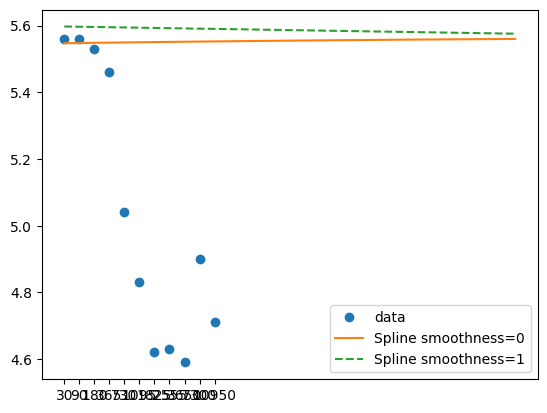

In [17]:
xdata = Curvas.columns.to_list()
ydata = Curvas.loc['2023-09-28'].to_list()

EjemploSplineInterpolator(xdata, ydata)

In [18]:
type(Curvas.loc['2023-09-28'].to_list())

list

In [8]:
#Creo función para calcular los precios del AL30 según cada curva de tasas
def NPV(cf, date, rates):
    date = pd.to_datetime(date)
    cf2 = cf.loc[df.index > date, ['A+R']]
    cf2['Days to payment'] = (cf2.index - date).days
    cf2['Risk Free Rate'] = cf2['Days to payment'].map(rates['Rate'])
    cf2['Present Value Factor'] = (1 + cf2['Risk Free Rate'] )**-(cf2['Days to payment']/365)
    cf2['Cash Flow Present Value'] = cf2['A+R'] * cf2['Present Value Factor']
    price = sum(cf2['Cash Flow Present Value'])
    return price


In [9]:
NPV(df, '19-9-2023', ETTI )

89.42889874352463

In [6]:
#Armo función para calcular el valor actual de la pérdida esperada a cada fecha
def LossPV(cf, date, rates):
    date = pd.to_datetime(date)
    cf2 = cf.loc[df.index > date, ['VR','A+R']]
    cf2['Risk Free Price'] = [NPV(df, dates, rates) + cupon['A+R'] for dates, cupon in cf2.iterrows()]
    cf2['Recovery'] = cf2['VR'] * RR
    cf2['Default Loss'] = cf2['Risk Free Price'] - cf2['Recovery']
    cf2['Days to payment'] = (cf2.index - date).days
    cf2['Risk Free Rate'] = cf2['Days to payment'].map(ETTI['Rate'])
    cf2['Present Value Factor'] = (1 + cf2['Risk Free Rate'] )**-(cf2['Days to payment']/365)
    cf2['Present Value of Default Loss'] = cf2['Present Value Factor'] * cf2['Default Loss']
    PVDL = sum(cf2['Present Value of Default Loss'])
    return PVDL


LossPV(df, pd.to_datetime('19-9-2023'), ETTI )


C:\Users\juana\AppData\Local\Temp\ipykernel_17932\2775376515.py:16: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  LossPV(df, pd.to_datetime('19-9-2023'), ETTI )


408.660840582522

In [7]:
# Armo un data Frame donde voy a ir colocando cada uno de las columnas para el
#cálculo de las probabilidades

summary = prices
summary['Risk Free Value'] = [NPV(df, dates, ETTI) for dates, prices in summary.iterrows()]
summary['Credit Spread'] = summary['Risk Free Value'] - summary['close']
summary['Present Value of Default Loss'] = [LossPV(df, dates, ETTI) for dates, prices in summary.iterrows()]
summary['Default Probability'] = summary['Credit Spread'] / summary['Present Value of Default Loss'] * 2
summary


,close,Risk Free Value,Credit Spread,Present Value of Default Loss,Default Probability
date,,,,,
2020-09-14,51.870,80.623681,28.753681,577.539845,0.099573
2020-09-15,51.080,80.632345,29.552345,577.601908,0.102328
2020-09-16,47.960,80.641010,32.681010,577.663977,0.113149
2020-09-17,46.900,80.649675,33.749675,577.726052,0.116836
2020-09-18,47.100,80.658342,33.558342,577.788135,0.116161
...,...,...,...,...,...
2023-09-20,30.140,89.438509,59.298509,408.704755,0.290178
2023-09-21,29.400,89.448120,60.048120,408.748675,0.293814
2023-09-22,29.390,89.457732,60.067732,408.792599,0.293879
